<a href="https://colab.research.google.com/github/StefanoGiacomelli/e2panns/blob/main/E2PANNs_Scheduler_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections.abc import Iterable
from math import log, cos, pi, floor
from torch.optim.lr_scheduler import _LRScheduler

class CyclicCosineDecayLR(_LRScheduler):
    def __init__(self,
                 optimizer,
                 init_decay_epochs,
                 min_decay_lr,
                 restart_interval=None,
                 restart_interval_multiplier=None,
                 restart_lr=None,
                 warmup_epochs=None,
                 warmup_start_lr=None,
                 last_epoch=-1,
                 verbose=False):
        if not isinstance(init_decay_epochs, int) or init_decay_epochs < 1:
            raise ValueError("init_decay_epochs must be a positive integer.")
        if isinstance(min_decay_lr, Iterable) and len(min_decay_lr) != len(optimizer.param_groups):
            raise ValueError("len(min_decay_lr) must match len(optimizer.param_groups).")

        if restart_interval is not None and (not isinstance(restart_interval, int) or restart_interval < 1):
            raise ValueError("restart_interval must be a positive integer or None.")
        if restart_interval_multiplier is not None and \
           (not isinstance(restart_interval_multiplier, float) or restart_interval_multiplier <= 0):
            raise ValueError("restart_interval_multiplier must be a positive float or None.")
        if isinstance(restart_lr, Iterable) and len(restart_lr) != len(optimizer.param_groups):
            raise ValueError("len(restart_lr) must match len(optimizer.param_groups).")

        if warmup_epochs is not None:
            if not isinstance(warmup_epochs, int) or warmup_epochs < 1:
                raise ValueError("warmup_epochs must be a positive integer or None.")
            if warmup_start_lr is None:
                raise ValueError("warmup_start_lr must be set if warmup_epochs is not None.")
            if not (isinstance(warmup_start_lr, float) or isinstance(warmup_start_lr, Iterable)):
                raise ValueError("warmup_start_lr must be a float or iterable of floats.")
            if isinstance(warmup_start_lr, Iterable) and len(warmup_start_lr) != len(optimizer.param_groups):
                raise ValueError("len(warmup_start_lr) must match len(optimizer.param_groups).")

        group_num = len(optimizer.param_groups)
        self._warmup_start_lr = ([warmup_start_lr] * group_num
                                 if isinstance(warmup_start_lr, float)
                                 else warmup_start_lr)
        self._warmup_epochs = 0 if warmup_epochs is None else warmup_epochs
        self._init_decay_epochs = init_decay_epochs
        self._min_decay_lr = ([min_decay_lr] * group_num
                              if isinstance(min_decay_lr, float)
                              else min_decay_lr)
        self._restart_lr = ([restart_lr] * group_num
                            if isinstance(restart_lr, float)
                            else restart_lr)
        self._restart_interval = restart_interval
        self._restart_interval_multiplier = restart_interval_multiplier

        super(CyclicCosineDecayLR, self).__init__(optimizer, last_epoch, verbose=verbose)

    def get_lr(self):
        # Warmup phase
        if self._warmup_epochs > 0 and self.last_epoch < self._warmup_epochs:
            return self._calc(self.last_epoch,
                              self._warmup_epochs,
                              self._warmup_start_lr,
                              self.base_lrs)
        # Initial cosine decay phase
        elif self.last_epoch < self._init_decay_epochs + self._warmup_epochs:
            return self._calc(self.last_epoch - self._warmup_epochs,
                              self._init_decay_epochs,
                              self.base_lrs,
                              self._min_decay_lr)
        # Post-initial phase: possible restarts
        else:
            if self._restart_interval is not None:
                # Fixed-length cycles
                if self._restart_interval_multiplier is None:
                    cycle_epoch = ((self.last_epoch - self._init_decay_epochs
                                    - self._warmup_epochs)
                                   % self._restart_interval)
                    lrs = self.base_lrs if self._restart_lr is None else self._restart_lr
                    return self._calc(cycle_epoch,
                                      self._restart_interval,
                                      lrs,
                                      self._min_decay_lr)
                # Geometrically increasing cycle length
                else:
                    n = self._get_n(self.last_epoch - self._warmup_epochs - self._init_decay_epochs)
                    sn_prev = self._partial_sum(n)
                    cycle_epoch = self.last_epoch - sn_prev - self._warmup_epochs - self._init_decay_epochs
                    interval = self._restart_interval * self._restart_interval_multiplier ** n
                    lrs = self.base_lrs if self._restart_lr is None else self._restart_lr
                    return self._calc(cycle_epoch,
                                      interval,
                                      lrs,
                                      self._min_decay_lr)
            else:
                return self._min_decay_lr

    def _calc(self, t, T, lrs, min_lrs):
        return [
            min_lr + (lr - min_lr) * ((1 + cos(pi * t / T)) / 2)
            for lr, min_lr in zip(lrs, min_lrs)
        ]

    def _get_n(self, epoch):
        # For geometric cycle length
        _t = 1 - (1 - self._restart_interval_multiplier) * epoch / self._restart_interval
        return floor(log(_t, self._restart_interval_multiplier))

    def _partial_sum(self, n):
        # Sum of geometric series to find total epochs spanned by completed cycles
        return (self._restart_interval * (1 - self._restart_interval_multiplier ** n)
                / (1 - self._restart_interval_multiplier))

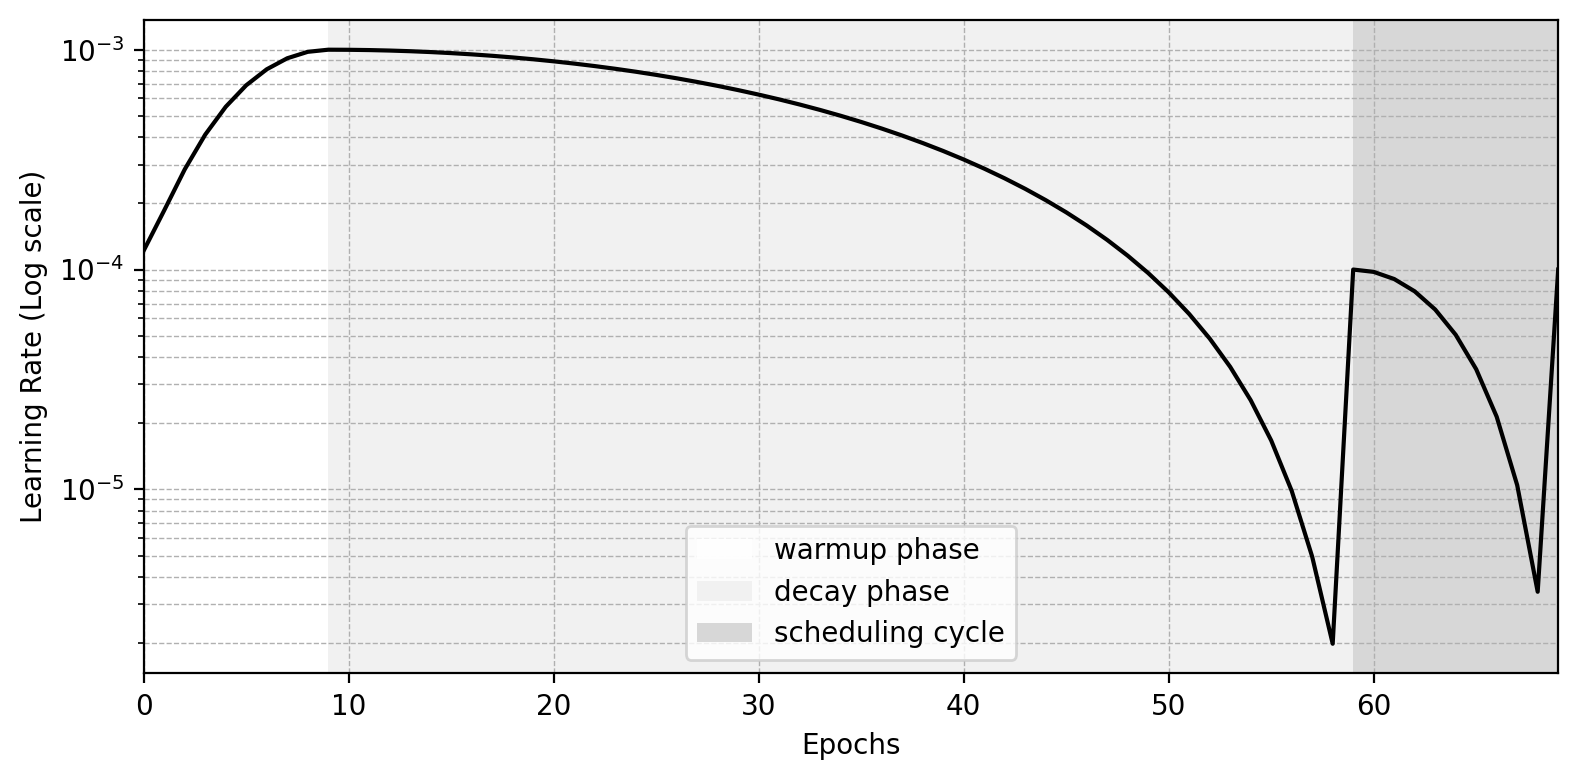

In [ ]:
# Create a dummy model
model = torch.nn.Linear(10, 1)

# Initialize an optimizer with a placeholder learning rate (base LR)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Define the scheduler with the parameters you specified
scheduler = CyclicCosineDecayLR(optimizer=optimizer,
                                init_decay_epochs=50,       # decay_epochs
                                min_decay_lr=1e-6,          # eta_min
                                restart_interval=10,
                                restart_interval_multiplier=None,  # no geometric expansion
                                restart_lr=1e-4,            # restart_eta
                                warmup_epochs=10,           # warmup_epochs
                                warmup_start_lr=1e-4,       # warmup_eta
                                verbose=False)

num_epochs = 1000
lr_values = []

for epoch in range(num_epochs):
    # "Train" your model here (dummy step)
    # model(...) -> compute loss -> loss.backward() -> optimizer.step() etc.

    # Step the scheduler AFTER each epoch (or iteration, depending on your use case)
    scheduler.step()

    # Record the current LR (assuming only one param group)
    current_lr = optimizer.param_groups[0]["lr"]
    lr_values.append(current_lr)

# Plot 1: Zoomed-in (epochs 0–70) to visualize warmup, decay, and first cycle
zoom_end = 70  # includes warmup (10 epochs), decay (50 epochs), and 1 full cycle (10 epochs)
plt.figure(figsize=(8, 4))  # High-res figure
plt.plot(range(zoom_end), lr_values[:zoom_end], color="black")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate (Log scale)")
plt.yscale("log")  # Log scale for clarity
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Highlight regions with colored spans:
# Warmup phase: epochs 0 to 9 (white)
plt.axvspan(0, 9, facecolor='white', alpha=0.9, label='warmup phase')
# Decay phase: epochs 9 to 59 (very light grey)
plt.axvspan(9, 59, facecolor='#f0f0f0', alpha=0.9, label='decay phase')
# Cycle phase: epochs 59 to 69 (darker, yet light grey)
plt.axvspan(59, 69, facecolor='#d3d3d3', alpha=0.9, label='scheduling cycle')

# Set x-axis to start at 0 and remove additional margins
plt.xlim(0, zoom_end-1)
plt.gca().margins(x=0)

plt.legend(loc='best')
plt.tight_layout()
plt.savefig("scheduler_zoom.png", dpi=600)  # Save high-res PNG
plt.show()

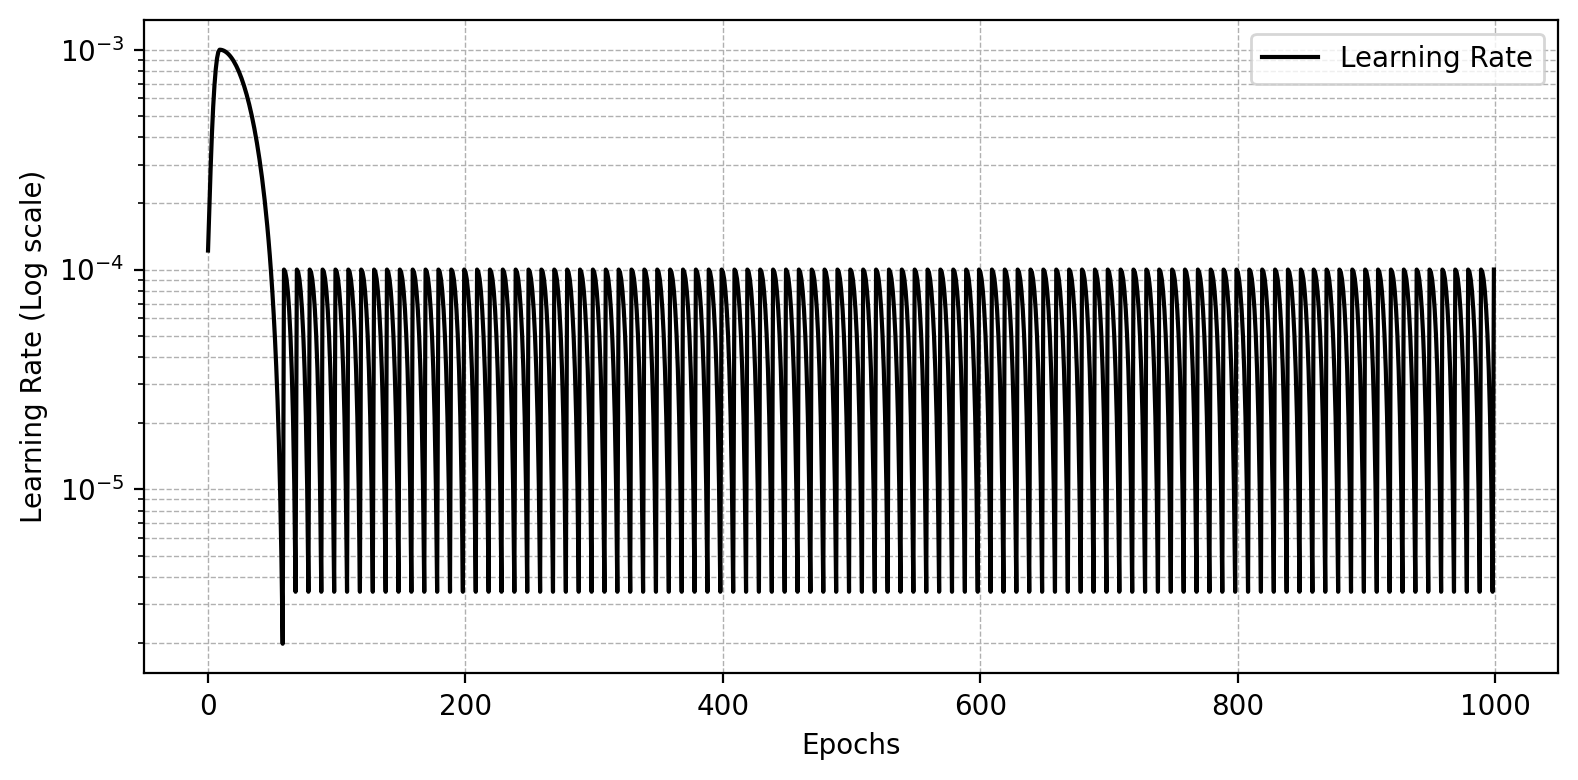

In [ ]:
# Plot 2: Full 1000 epochs
plt.figure(figsize=(8, 4))  # High-res figure
plt.plot(range(num_epochs), lr_values, label="Learning Rate", color="black")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate (Log scale)")
#plt.title("Cyclic Cosine Decay LR over 1000 epochs")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("scheduler_full.png", dpi=600)
plt.show()